### Initiation

In [4]:
# To manipulate arrays
import numpy as np 
# To import images 

# To handle track DataFrames
import pandas as pd

# To import images
from skimage import io 
from skimage.io import imread

# For TrackPy
import trackpy as tp

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import data
import napari

# To create interactive elements
import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout
from ipywidgets.embed import embed_minimal_html, dependency_state

# Image processing and filters
from skimage.filters import difference_of_gaussians

# Iteration tools such as groupby 
import itertools

# For directories 
import os

# For reloading a library when testing
import importlib

# For deleting/reloading modules in another file for code testing
import sys

# For statistics
from scipy import stats

# Import trackArrayTools
from trackArrayTools import *

#rSNAPsim_IP
cwd = os.getcwd()  # get current working director
#os.chdir('../rSNAPsim_IP/rSNAPsim_IP/') # assume rSNAPsim_IP is  one directory up
os.chdir('/Users/ccialek/Documents/GitHub/single-molecule-tracking-python/Code/rSNAPsim_IP/rSNAPsim_IP/')
import rSNAPsim_IP as rss_IP #importing rSNAPsim.
os.chdir(cwd) # change back to original current directory (the directory this file is in)

#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *

Error importing cv2, the manual selection for the mask will not work.
         _____ _   _____    ____       _              ________ 
   _____/ ___// | / /   |  / __ \_____(_)___ ___     /  _/ __ \
  / ___/\__ \/  |/ / /| | / /_/ / ___/ / __ `__ \    / // /_/ /
 / /   ___/ / /|  / ___ |/ ____(__  ) / / / / / /  _/ // ____/ 
/_/   /____/_/ |_/_/  |_/_/   /____/_/_/ /_/ /_/  /___/_/      
                                                               



### Use Beads to make homography matrix

In [ ]:
beads_path ='/Volumes/BITTY/ht/beads/' 

In [24]:
# For display, so z and xy are shown properly when viewing track array
z_renorm = z_pixel_size/xy_pixel_size  

#  Track array filenames should be the following:
track_array_filename = 'Particles_' + video_3D_filename[:-4] + '_crop_pad_' + str(crop_pad) + '.tif' 
track_filename = track_array_filename[:-15] + '.csv'
[track_array_filename, track_filename]

['Particles_NT03har_crop_pad_5.tif', 'Particles_NT03har.csv']

In [14]:
# Loading the figure with beads so track array can be registered
# Dimension 1 is the number of channel. Red and Green. # Dimension 2 is the x axis. # Dimension 3 is the y axis.
figWithBeads = beads_path + 'Beads02.tif'
im_beads = io.imread(figWithBeads) # reading the image

In [15]:
# Using rSNAPSim to get the homography matrix to align the green/blue channels with red
temp_obj_beads = rss_IP.BeadsAlignment(im_beads)
[my_homography,positions_green,positions_red] = temp_obj_beads.make_beads_alignment()  # !!! Adjusted Luis' code to spit this info out

The number of spots detected for the red channel are:
(12, 2)
The number of spots detected for the green channel are:
(12, 2)

The homography matrix is:


In [16]:
# Check that the homography matrix is working:
my_homography_inverse = np.linalg.inv(my_homography)  # This is the transformation we use to shift green to red
print('[original distance, corrected distance (shift red to green), corrected distance (shift green to red)]' )
for i in np.arange(len(positions_green)):
    g0=positions_green[i]
    g=np.dot(my_homography_inverse,[positions_green[i,0],positions_green[i,1],1])[0:2]  # Correct green/blue
    r0=positions_red[i]
    r=np.dot(my_homography,[positions_red[i,0],positions_red[i,1],1])[0:2]  # What you'll do: shift red to green
    print([np.linalg.norm(g0-r0),np.linalg.norm(g0-r),np.linalg.norm(g-r0)]) # Check corrections

[original distance, corrected distance (shift red to green), corrected distance (shift green to red)]
[1.3111192, 0.20665082393305545, 0.2065400073168597]
[1.2391584, 0.3770796602083768, 0.37513356686959926]
[1.1031594, 0.2716684096428583, 0.27060413586510496]
[1.8265933, 0.25660641425603886, 0.2562533486800092]
[2.1591866, 0.15457005517039005, 0.15414952856322506]
[2.2941632, 0.17464558325743287, 0.17411763164007157]
[2.333299, 0.15237423773458425, 0.15225740151035808]
[2.3393996, 0.12890915994447538, 0.12771036673972233]
[2.359211, 0.21912901711082128, 0.2188633382412519]
[3.0235305, 0.16598236580823864, 0.1658806908972493]
[3.7424574, 0.9926937749169151, 0.9901327554141816]
[3.1506808, 0.16671259186290216, 0.1657748181106954]


### 
### Set current working directory, track array filenames, and basic parameters

In [67]:
# Enter in the following:
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension
working_directory = '/Volumes/BITTY/ht/Analysis/'
video_3D_filename_path = '/Volumes/BITTY/ht/'
video_3D_filename = 'TA17har.tif'

### Creating Track Array (only done once using original 3D video and tracks)

In [ ]:
# Read in the original 3D video 
video_3D = imread(video_3D_filename_path+video_3D_filename)

In [ ]:
# Create track array tif video from the original 3D video
# This only needs to be done once. Thereafter, can skip and just work with track array itself
video_3D = imread(video_3D_filename_path + video_3D_filename)
dims = list(video_3D.shape)
if len(dims) == 4:     # check if just a single channel video
    n_channels = 1
    n_frames, z_slices, height_y, width_x = dims
else:
    n_channels = min(dims)
    n_channels_index = dims.index(n_channels)   # find index of n_channels, which is assumed to be smallest dimension 
    dims.remove(n_channels)    
    video_3D = np.moveaxis(video_3D,n_channels_index,-1)  # move channels to last dimension of array (assumed by napari)
    n_frames, z_slices, height_y, width_x = dims

In [ ]:
# Read in the tracking file that corresponds to the original 3D video
tracks = pd.read_csv(video_3D_filename_path+track_filename) 
tracks.head()

In [63]:
viewer = napari.Viewer()
viewer.add_image(video_3D[:,:,:,:,0],name='red',blending="additive", scale=[z_renorm,1,1])
particles = tracks[['POSITION_T','POSITION_Z','POSITION_Y','POSITION_X']].values
viewer.add_points(particles, size=5, opacity = 0.3,
                edge_color = 'yellow',
                  face_color = 'yellow', symbol='ring')

<Points layer 'particles' at 0x7fa6d7f23d90>

In [64]:
create_particle_array_video(working_directory, track_array_filename, video_3D, 
                             tracks, crop_pad, xy_pixel_size, z_pixel_size, homography = my_homography)
# create_track_array_video(working_directory, track_array_filename, video_3D[0::10], tracks, crop_pad, xy_pixel_size, z_pixel_size)

### Track Array analysis: 3D background subtract + best-z projection + 2D background subtract

In [52]:
# Just in case you want to update trackArrayTools without having to restart Kernel
#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *

# Choose which track array you want to work with:
working_directory = '/Volumes/BITTY/ht/Analysis/'
track_array_filename ='Particles_' + video_3D_filename[:-4]+ '_crop_pad_5.tif'

# The corresponding tracking file should be in the same directory and have the following filename: 
track_filename = track_array_filename[:-15] + '.csv'

# Read in the track array video 
track_array_vid = imread(working_directory + track_array_filename)  # Read in track array .tif file

# Read in tracks as a "dataframes (df)"
track_array_df = pd.read_csv(working_directory + track_filename)

# Make sure color channels are the last dimension of the track array
dims = list(track_array_vid.shape)
if len(dims) != 3:     # check if just a single channel video
    n_channels = min(dims)
    n_channels_index = dims.index(n_channels)
    track_array_vid = np.moveaxis(track_array_vid,n_channels_index,-1)

In [53]:
# Step 0: Create the track array object:
#del sys.modules['trackArrayTools']  # Use this if you are coding new class methods and want to reread trackArrayTools.py file
#from trackArrayTools import *
ta = TrackArray(track_array_vid, track_array_df, crop_pad)

In [54]:
# Step 1: subtract background in 3D capsule mask
my_offset = [0,-1,-1]  ### For 3-color, could be [0,-1,-1]; BE CAREFUL, THIS WILL MAKE A MASK THAT IS SHIFTED IN Z FOR BLUE AND GREEN!!!
capsule_mask = ta.capsule_mask(crop_pad,crop_pad,2,1,0,z_offset=my_offset)
arr_bg = ta.local_background_subtract(ta.arr,capsule_mask)

# Check with napari
max = np.max(arr_bg,axis=(0,1,2)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
#napari_viewer(arr_bg,[z_renorm,1,1],int_range=my_range,layer=[capsule_mask[:,:,:,0],capsule_mask[:,:,:,1]])

In [55]:
# Step 2: Now do best-z projection
my_best_z_masks = ta.best_z_mask(1,0,z_offset = my_offset) # this part is same as above
arr_bg_best_z = ta.mask_projection(arr_bg, my_best_z_masks) # best-z projection

# Check with napari
max = np.max(arr_bg_best_z,axis=(0,1)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
#napari_viewer(arr_bg_best_z,[1,1],int_range=my_range)

In [56]:
# Step 3: Subtract background in donut rings from max projection  
arr_bg_best_z_bg = ta.local_background_subtract(arr_bg_best_z,ta.donut_mask_2D(5,1))

# Check with napari and show donut mask
max = np.max(arr_bg_best_z_bg,axis=(0,1)) # find max intensities for setting intensity range
my_range = [[0,max[ch]] for ch in np.arange(len(max))]
#napari_viewer(arr_bg_best_z_bg,[1,1],int_range=my_range,layer=[ta.donut_mask_2D(5,1)])

In [57]:
# Output background-subtracted and max-z projected track array 
output_filename_path = working_directory + track_array_filename[0:-4] + '_bg-sub_bestz_bg-sub.tif'
io.imsave(output_filename_path,
        arr_bg_best_z_bg, 
        resolution=(1/xy_pixel_size,1/xy_pixel_size))
# Also output just single background-subtracted image
output_filename_path = working_directory + track_array_filename[0:-4] + '_bg-sub_bestz.tif'
io.imsave(output_filename_path,
        arr_bg_best_z, 
        resolution=(1/xy_pixel_size,1/xy_pixel_size))
output_filename_path
output_filename_path

'/Volumes/BITTY/ht/Analysis/Particles_TA03har_crop_pad_5_bg-sub_bestz.tif'

### 
### Loop function: 

In [58]:
# Loop everything above on a collection of images, if desired:
working_directory = '/Volumes/BITTY/ht/Analysis/'
vids = ['NT03har.tif','TA03har.tif','TA17har.tif'] # Add to this list to batch process
my_offset = [0,-1,-1]  ### BE CAREFUL, THIS WILL MAKE A MASK THAT IS SHIFTED IN Z FOR BLUE AND GREEN!!!
for vs in vids:
    # Get track array video and tracking files:
    track_array_filename = 'Particles_'+vs[0:-4]+'_crop_pad_5.tif'
    track_filename = track_array_filename[:-15] + '.csv'

    # Read in the track array video 
    track_array_vid = imread(working_directory + track_array_filename)  # Read in track array .tif file

    # Read in tracks as a "dataframes (df)"
    track_array_df = pd.read_csv(working_directory + track_filename)

    # Make sure color channels are the last dimension of the track array
    dims = list(track_array_vid.shape)
    if len(dims) != 3:     # check if just a single channel video
        n_channels = min(dims)
        n_channels_index = dims.index(n_channels)
        track_array_vid = np.moveaxis(track_array_vid,n_channels_index,-1)

    # Step 0: make the track array object
    ta = TrackArray(track_array_vid, track_array_df, crop_pad)

    # Step 1: subtract background in 3D capsule mask
    my_offset = [0,-1,-1]  # !!!! This should probably be defaulted as [0,0,0]
    capsule_mask = ta.capsule_mask(crop_pad,crop_pad,2,1,0,z_offset=my_offset)
    arr_bg = ta.local_background_subtract(ta.arr,capsule_mask)
    
    # Step 2: Now do best-z projection
    my_best_z_masks = ta.best_z_mask(1,0,z_offset = my_offset) # this part is same as above
    arr_bg_best_z = ta.mask_projection(arr_bg, my_best_z_masks) # best-z projection
    
    # Step 3: Subtract background in donut rings from max projection  
    arr_bg_best_z_bg = ta.local_background_subtract(arr_bg_best_z,ta.donut_mask_2D(5,1))

    # Output background-subtracted and max-z projected track array 
    output_filename_path = working_directory + track_array_filename[0:-4] + '_bg-sub_bestz_bg-sub.tif'
    io.imsave(output_filename_path,
            arr_bg_best_z_bg, 
            resolution=(1/xy_pixel_size,1/xy_pixel_size))
    
    # Also output just single background-subtracted image
    output_filename_path = working_directory + track_array_filename[0:-4] + '_bg-sub_bestz.tif'
    io.imsave(output_filename_path,
            arr_bg_best_z, 
            resolution=(1/xy_pixel_size,1/xy_pixel_size))
    output_filename_path
    output_filename_path

### Concatentate all track arrays of interest into one giant track array object

In [5]:
# Specify basic track array parameters (in case not done above)
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
xy_pixel_size = 130   # voxel  xy dimensions in crops
z_pixel_size = 500   # voxel z dimension

# Specify working directory and files you want to read in:
working_directory ='C:/Users/tim_s/Documents/Python Scripts/LabScripts/TestData/'
vids_TA =['TA03har.tif'] 
vids_TL =['TA03har.tif'] 
crop_pad = 5    # specifies the size of crops in track arary. If 5, then crops are (2*5 + 1 = 11) x 11
track_array_filenames_TA = ['Particles_' + videos[:-4] + '_crop_pad_' + 
                          str(crop_pad) + '_bg-sub_bestz.tif' for videos in vids_TA]
track_array_filenames_TL = ['Particles_' + videos[:-4] + '_crop_pad_' + 
                           str(crop_pad) + '_bg-sub_bestz_bg-sub.tif' for videos in vids_TL]

In [6]:
# Read in all track array videos and corresponding tracking files:
track_array_vids_TA = [imread(working_directory + i) for i in track_array_filenames_TA]  # Read in track array .tif file
track_files_TA = [pd.read_csv(working_directory + 'Particles_' + videos[:-4]+'.csv') for videos in vids_TA] 

track_array_vids_TL = [imread(working_directory + i) for i in track_array_filenames_TL]  # Read in track array .tif file
track_files_TL = [pd.read_csv(working_directory + 'Particles_' + videos[:-4]+'.csv') for videos in vids_TL] 

# Concatentate the tracking files:
tracks_all_TA = pd.concat(track_files_TA, axis=0, sort=False) 
tracks_all_TL = pd.concat(track_files_TL, axis=0, sort=False) 

# Concatenate the tracking_array_vids:
track_array_all_TA = concat_crop_array_vids(track_array_vids_TA)
track_array_all_TL = concat_crop_array_vids(track_array_vids_TL)

# Make large, single track array:
ta_TA = TrackArray(track_array_all_TA, tracks_all_TA, crop_pad)
ta_TL = TrackArray(track_array_all_TL, tracks_all_TL, crop_pad)

In [7]:
# View the background-subtracted track array and disk mask to measure intensities in:
napari_viewer(ta_TA.moving_avg(ta_TA.arr,1),[1,1],int_range=[[0,10000] for i in np.arange(ta_TA.n_channels())],
              layer=[ta_TA.donut_mask_2D(3,1),ta_TA.disk_mask_2D(3)])

In [81]:
# View the background-subtracted track array and disk mask to measure intensities in:
napari_viewer(ta_TL.moving_avg(ta_TL.arr,1),[1,1],int_range=[[-2000,10000] for i in np.arange(ta_TA.n_channels())],
              layer=[ta_TL.donut_mask_2D(3,1),ta_TL.disk_mask_2D(3)])

### Figures generated from the concatenated track array object

In [8]:
# Choose working directory where you want to save figures and data:
os.chdir('C:/Users/tim_s/OneDrive - Colostate/Stasevich Lab/Our papers/Ago2Tethering/TimFastTrackAnalysis/Plots/')

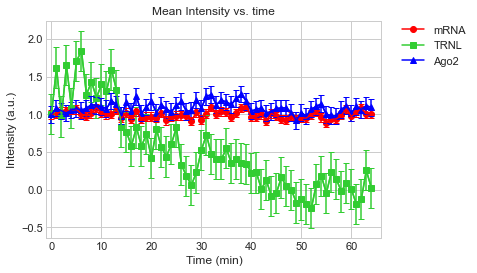

In [10]:
# Try using only 3D bg-subtracted data
my_int_TA_sig = ta_TA.int_in_mask(ta_TA.arr,np.array([ta_TA.disk_mask_2D(3)]))
my_int_TA_bg = ta_TA.int_in_mask(ta_TA.arr,np.array([ta_TA.donut_mask_2D(5,1)]))
my_arr = my_int_TA_sig - my_int_TA_bg # Choose track array
delta_t = 1 
my_times = np.arange(my_arr.shape[1])*delta_t
my_mean_intensity_plot(np.ma.masked_equal(my_arr,0),channels=[0,1,2],labels=['mRNA','TRNL','Ago2'],xlim=[-1,66],
               colors=['red','limegreen','blue'],markers=['o','s','^'],renorm=True, error='sem', 
                       style='seaborn-whitegrid', axeslabels=['Time (min)', 'Intensity (a.u.)'],
                       times = my_times, filename='test.svg')

In [27]:
def background_in_mask(crop, mask):    
    """
    Returns mean intensity within mask region of the inputted crop.
    """
    myaxis =tuple(np.arange(len(crop.shape))[0:-1]) # Axis for summing mean (channels not included)
    return np.mean(np.ma.masked_equal(crop*mask,0),axis=myaxis).data # mean, ignoring zeros and not summing over channel

In [62]:
np.zeros([5,3])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [99]:
   def local_background_subtract(crop_array, mask_array):  ### !!! would be nice to work on something other than self.arr
        """Returns crops after subtracting the background signal measured in masks)
        """
        crops = ta_TA.array_to_crops(crop_array) # convert to indexable format w/ dims (N,T,Z,Y,X,C) 
        masks = ta_TA.array_to_crops(mask_array) # convert to indexable format w/ dims (N,T,Z,Y,X,C)
        n_tracks = ta_TA.n_tracks()
        n_frames = ta_TA.n_frames()
        n_channels = ta_TA.n_channels()
        n_dim = len(crops.shape)
        output = np.zeros(crops.shape)
        for n in np.arange(n_tracks):
            for t in np.arange(n_frames):
                background = ta_TA.background_in_mask(crops[n,t],masks[n,t])
                for ch in np.arange(n_channels):
                    if n_dim == 6:
                        output[n,t,:,:,:,ch] = crops[n,t,:,:,:,ch] - background[ch] # !!! Doesn't work for single channel image
                    if n_dim == 5:
                        output[n,t,:,:,ch] = crops[n,t,:,:,ch] - background[ch]
        return output#ta_TA.crops_to_array(output)

In [86]:
crop = ta_TA.array_to_crops(np.array([arr_bg_best_z]))[0][10]
mask = ta_TA.array_to_crops(np.array([ta.donut_mask_2D(5,1)]))[0][10]
[tuple(np.arange(len(crop.shape))[0:-1]),background_in_mask(crop,mask)]

[(0, 1, 2), array([155.84848485, 416.8125    , 247.6       ])]

In [87]:
crop = ta_TA.array_to_crops(arr_bg_best_z)[0][10]
mask = ta_TA.array_to_crops(ta.donut_mask_2D(5,1))[0][10]
[tuple(np.arange(len(crop.shape))[0:-1]),background_in_mask(crop,mask)]

[(0, 1), array([155.84848485, 416.8125    , 247.6       ])]

In [88]:
[np.array_equal(np.array([arr_bg_best_z]),ta_TA.arr),np.array([arr_bg_best_z]).shape,
 np.array([ta.donut_mask_2D(5,1)]).shape]

[True, (1, 1628, 715, 3), (1, 1628, 715, 3)]

In [101]:
#arr_bg_best_z_bg = ta.local_background_subtract(arr_bg_best_z,ta.donut_mask_2D(5,1))
t4 = local_background_subtract(arr_bg_best_z,ta_TA.donut_mask_2D(5,1))
t4b = local_background_subtract(np.array([arr_bg_best_z]),np.array([ta_TA.donut_mask_2D(5,1)]))
#t4c = ta_TA.array_to_crops(t4)
#t4d = ta_TA.array_to_crops(t4b)
t5 = ta_TA.array_to_crops(arr_bg_best_z)
t5b = ta_TA.array_to_crops(np.array([arr_bg_best_z]))

In [110]:
t6 = ta_TA.crops_to_array(t4)
t6b = ta_TA.crops_to_array(t4b)
[t6.shape,t6b.shape,np.array_equal(t4,t4b[:,:,0,:,:,:]),np.array_equal(t6,t6b[0])]

[(1628, 715, 3), (1, 1628, 715, 3), True, False]

In [118]:
[t6[11:14,11:14,1].T,t6b[0,11:14,11:14,1].T]

[array([[-348.09677419, -348.09677419, -348.09677419],
        [-348.09677419, -348.09677419, -294.09677419],
        [-348.09677419, -348.09677419, -161.09677419]]),
 array([[-348.09677419, -348.09677419, -348.09677419],
        [-348.09677419, -348.09677419, -348.09677419],
        [-348.09677419, -294.09677419, -161.09677419]])]

In [106]:
[t4.shape,t4b.shape,np.array_equal(t4,t4b[:,:,0,:,:,:])]

[(148, 65, 11, 11, 3), (148, 65, 1, 11, 11, 3), True]

In [104]:
[t5.shape,t5b.shape, t4.shape,t4[0,0,0:3,0:3,1],t4b[0,0,0,0:3,0:3,1],t5[0,0,:,:,1],t5b[0,0,0,:,:,1]]

[(148, 65, 11, 11, 3),
 (148, 65, 1, 11, 11, 3),
 (148, 65, 11, 11, 3),
 array([[-383.77777778, -383.77777778,  218.22222222],
        [-383.77777778, -301.77777778, -220.77777778],
        [-320.77777778, -166.77777778,   52.22222222]]),
 array([[-383.77777778, -383.77777778,  218.22222222],
        [-383.77777778, -301.77777778, -220.77777778],
        [-320.77777778, -166.77777778,   52.22222222]]),
 array([[   0,    0,  602,  557,   72,  450,  661,    0,    0,    0,  288],
        [   0,   82,  163,    0,  302,  350,  560,  391,  414,    0,   70],
        [  63,  217,  436,  165,  440,  132,   93,   33,  317,  178,   87],
        [   0,  631,  206,  210,  818,  417,  282,  391,    7,    0,   25],
        [ 384,   72,  826,  710,  620,  234,  416,  321,    0,  322,  482],
        [ 775,  150,  660,  675,  957,  761,  684,  358,  615,   48,  282],
        [ 233,  719,  318,  100,  433,  210,  328,   62,  559,  445,  139],
        [ 372,  652,  663,  203,  847,  168,  770,  647,  283,

In [40]:
[t4.shape,t4b[0].shape,np.array_equal(t4,t4b[0]),t4[0:5,0,1],t4b[0][0:5,0,1]]

[(1628, 715, 3),
 (1628, 715, 3),
 False,
 array([-383, -383, -320, -383,    0], dtype=int16),
 array([-383, -383,  218,  173, -311], dtype=int16)]

In [132]:
t3 = ta_TA.local_background_subtract(ta_TA.arr,ta_TA.donut_mask_2D(5,1))


In [150]:
[t4.shape,ta_TL.arr.shape,ta_TA.donut_mask_2D(5,1).shape,ta.donut_mask_2D(5,1).shape]

[(1, 1628, 715, 3), (1, 1628, 715, 3), (1628, 715, 3), (1628, 715, 3)]

In [154]:
np.array_equal(t4,ta_TL.arr[0])

True

In [135]:
t1 = my_int_TA_sig - my_int_TA_bg
t2 = my_int_TL_sig

In [141]:
[t1.shape, t2.shape, t3.shape,ta_TL.arr.shape, t1[0:3,0,1],t2[0:3,0,1], t4[0:3,0,1],ta_TL.arr[0:3,0,1]]

[(148, 65, 3),
 (148, 65, 3),
 (1, 1628, 715, 3),
 (1, 1628, 715, 3),
 array([ 97.53256705, 829.01538462, 263.24915825]),
 array([ 97.72413793, 700.75862069, 200.17241379]),
 array([-383, -383, -320], dtype=int16),
 array([[-115., -383., -100.]])]

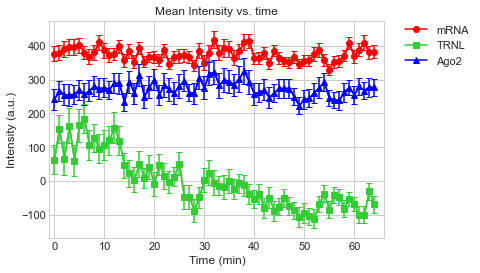

In [84]:
# Try using only 3D bg-subtracted data
my_int_TL_sig = ta_TL.int_in_mask(ta_TL.arr,np.array([ta_TL.disk_mask_2D(3)]))
my_int_TL_bg = ta_TL.int_in_mask(ta_TL.arr,np.array([ta_TL.donut_mask_2D(5,1)]))
my_arr = my_int_TL_sig # Choose track array
delta_t = 1 
my_times = np.arange(my_arr.shape[1])*delta_t
my_mean_intensity_plot(np.ma.masked_equal(my_arr,0),channels=[0,1,2],labels=['mRNA','TRNL','Ago2'],xlim=[-1,66],
               colors=['red','limegreen','blue'],markers=['o','s','^'],renorm=False, error='sem', 
                       style='seaborn-whitegrid', axeslabels=['Time (min)', 'Intensity (a.u.)'],
                       times = my_times, filename='test.svg')